# Figs 1,3,5 from Matthews+ 2022
This notebook contains routines for reproducing some of the figures from J. H. Matthews et al. 2022, "How do magnetic field models affect astrophysical limits on light axion-like particles? An X-ray case study with NGC 1275". 

<div class="alert alert-info">
At the moment, this page is incomplete and minimally documented, but I will gradually add to it. All the plots are missing results from the Gaussian random field models at the moment because I haven't incorporated those models into alpro directly. 
</div> 

For limits plots, see the NGC1275 limits page.

## Figure 1: Pressure Profile

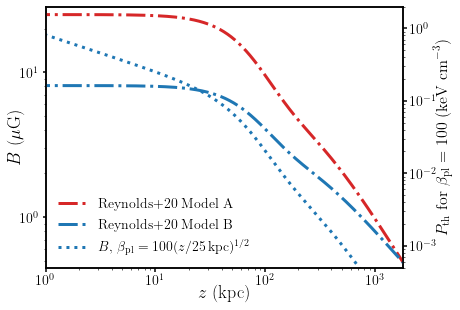

In [5]:
%matplotlib inline 
import numpy as np 
import alpro 
import matplotlib.pyplot as plt 
from alpro.models import unit

pressure_conversion = 1.0 / (1000.0 * unit.ev)
beta = 100.0

def B_from_P_ylim(Ptuple):
    B1 = 1e6 * np.sqrt((Ptuple[0] / pressure_conversion / beta)  * 8.0 * np.pi)
    B2 = 1e6 * np.sqrt((Ptuple[1] / pressure_conversion / beta)  * 8.0 * np.pi)
    return (B1, B2)

def beta_func(r, alpha=0.5, beta0=100, r0 = 25.0):
    beta = beta0 * (r/r0) ** alpha
    return (beta)

def make_fig1():

    fig, ax2 = plt.subplots()
    ax = ax2.twinx()

    models = ["1275a", "1275b"]
    label = ["A", "B"]
    color = ["C3", "C0"]
    for i, mod_name in enumerate(models):
        s = alpro.Survival(mod_name)
        s.init_model()

        r = np.logspace(-1,np.log10(2000), 1000)

        B = s.cluster.get_B(r)
        PB = (B ** 2) / 8.0 / np.pi 
        ax.plot(r, pressure_conversion * PB * beta, label="Reynolds$+$20 Model {}".format(label[i]), c=color[i], ls="-.", lw=3)

        if mod_name == "1275b":
            s.cluster.plasma_beta = beta_func
            s.init_model()
            ax2.plot(r, 1e6*s.cluster.get_B(r), ls=":", c="C0", label=r"$B$, $\beta_{\rm pl} = 100 (z/25 {\rm kpc})^{1/2}")
            ax.plot(r, s.cluster.get_B(r), ls=":", c="C0", label=r"$B,\,\beta_{\rm pl} = 100 (z/25\,{\rm kpc})^{1/2}$")


    ax.set_ylim(5e-4, 2)
    ax2.set_ylim(B_from_P_ylim(ax.get_ylim()))
    ax2.set_xlabel("$z$~(kpc)", fontsize=18, labelpad=-2)
    ax.set_ylabel(r"$P_{\rm th}~{\rm for}~\beta_{\rm pl} = 100~({\rm keV~cm}^{-3})$", fontsize=16, labelpad=-2)
    ax.legend(fontsize=14, frameon=False, loc=3)
    ax2.set_xlim(1,1800)
    ax.get_shared_y_axes().join(ax,ax2)

    ax2.set_ylabel(r"$B~(\mu {\rm G})$", fontsize=18, labelpad=-5)
    plt.loglog()
    
alpro.util.set_default_plot_params(tex=True)
make_fig1()

## Figure 3: Rotation Measures

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


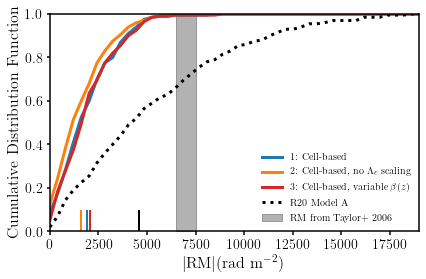

In [2]:
def get_rm_models(model_kwargs, rm_reject=False):
    N = 200
    rm = np.zeros(N)
    for i in range(N):
        s = setup_model(i, 1e-13 * 1e-9, 1e-13, **model_kwargs)
        rm[i] = s.domain.get_rm(cell_centered=False)
    return (np.fabs(rm), np.median(np.fabs(rm)))

def setup_model(i, g, mass, mod = "1275b", lc_scale = True, var_beta = False):
    s = alpro.Survival(mod)
    s.init_model()
    if var_beta:
        s.cluster.plasma_beta = beta_func
    if lc_scale == False:
        s.set_coherence_r0(None)
    s.domain.create_box_array(1800.0, i, s.coherence_func, r0=0.0)
    s.set_params(g = g, mass = mass)
    return (s)

ls = ["-", "-", "-", ":"]
colors = ["C0", "C1", "C3", "k"]
model = ["1275b", "1275b", "1275b", "1275a"]
labels = ["1: Cell-based", r"2: Cell-based, no $\Lambda_c$ scaling", r"3: Cell-based, variable $\beta(z)$", "R20 Model A"]
var_betas = [False, False, True, False]
lc_scales = [True, False, True, True]
imods = np.arange(len(ls))
bins = np.linspace(0,4e4,100)
params = zip(imods, model, var_betas, lc_scales, labels, colors)
fig = plt.figure()

for imod, mod, var_beta, lc_scale, label, color in params:
    model_kwargs = {"mod": mod, "var_beta": var_beta, "lc_scale": lc_scale}

    iseed = 0

    rms, median = get_rm_models(model_kwargs)
    hist, bin_edges = np.histogram(rms, bins=bins)
    cdf = np.cumsum(hist) / np.sum(hist)
    plt.plot(bin_edges[:-1], cdf, color=color, lw=3, label=labels[imod], ls = ls[imod])
    plt.vlines([median], 0, 0.1, color=color, lw=2)
    
plt.ylabel("Cumulative Distribution Function")
plt.xlabel(r"$|{\rm RM| (rad~m^{-2}})$")
plt.fill_between([6500,7500], 0, 1, color="k", alpha=0.3, label= "RM from Taylor$+$ 2006")
plt.ylim(0,1)
plt.xlim(0,19000)
plt.legend(loc=4, frameon=False)
plt.subplots_adjust(hspace=0.05, wspace=0.35, right=0.98)

## Figure 5: Magnetic Field Models and survival probabilities
This code will reproduce figure 5 from the paper. To avoid a fairly lengthy calculation of the mean survival probability, the code uses precalculated values stored in this repository. 

| Model | $N$ | $B$-Field  | $\Lambda_c$ scaling? | $\beta_{\rm pl}(z)$                 | Range of scales (kpc) |  Median $|{\rm RM}|\,({\rm rad\,m^{-2}})$                      | Colour                     |
|-------|-----|------------|------|-------------------------------|------------|-------------------------------------------------|-----------|
| 1     | 200 | Cell-based | Yes  | constant, 100                | $3.5-10$   | 1915    | Blue      |
| 2     | 200 | Cell-based | No   | constant, 100                | $3.5-10$   | 1603    | Orange    |
| 3     | 200 | Cell-based | Yes  | $100~\sqrt{z/25\,{\rm kpc}}$ | $3.5-10$   | 2045    | Red       |


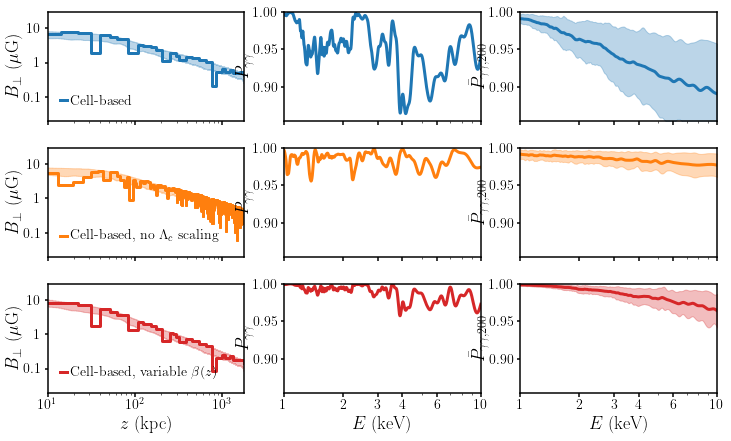

In [3]:
g = 1e-12 * 1e-9
mass = 1e-13
from scipy.interpolate import interp1d

def set_pgg_axes(ax, xtick, ymin=0.855):
    ax.set_xscale("log")
    ax.set_xlim(1,10)
    ax.set_ylim(ymin,1)
    xticks_to_use = [1,2,3,4,6,10]
    ax.set_xticks(xticks_to_use)
    if xtick:
        ax.set_xlabel("$E$ (keV)", fontsize=18)
        ax.set_xticklabels([str(i) for i in xticks_to_use])
    else:
        ax.set_xticklabels([])

def get_mean_sd_models(model_kwargs, rm_reject=False):
    N = 200
    rinterp = np.linspace(0,1800,1801)
    Bfine = np.zeros((N,len(rinterp)))
    moments = np.zeros((2,len(rinterp)))
    for i in range(N):
        s = setup_model(i, g, mass, **model_kwargs)
        rinterp = np.linspace(0,1800,1801)
        interp_func = interp1d(s.domain.rcen, 1e6*s.domain.B, bounds_error=False, fill_value="extrapolate")
        Bfine[i,:] = interp_func(rinterp)

    moments[0,:] = np.mean(Bfine, axis=0)
    moments[1,:] = np.std(Bfine, axis=0)
    return moments

def plot_model(ax, s, label, color, xtick, moments):
    rinterp = np.linspace(0,1800,1801)
    ax.step(s.domain.r, 1e6*s.domain.B, label=label, where="post", c=color)
    ax.fill_between(rinterp, y1=moments[0,:]-moments[1,:], y2=moments[0,:]+moments[1,:], color=color, alpha=0.3, step="mid")
    ax.set_yscale("log")
    ax.set_xscale("log")
    if xtick:
        ax.set_xlabel("$z$~(kpc)", fontsize=18)
    ax.legend(fontsize=14, frameon=False, loc=3, handlelength=0.5, handletextpad=0.2)
    ax.set_ylabel(r"$B_\perp~(\mu {\rm G})$", fontsize=18, labelpad=-2)
    ax.set_xlim(10,1800)
    ax.set_ylim(2e-2,30)
    yticks = [0.1,1,10]
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(i) for i in yticks])
    if xtick == False:
        ax.set_xticklabels([])

def plot_pgg(ax, s, label, color, xtick):
    energies = np.logspace(3,4,1000)
    P, _ = s.propagate_with_pruning(s.domain, energies, threshold=0.1, refine=10, required_res=3)
    ax.plot(energies/1e3, 1.0 - P, c=color)
    set_pgg_axes(ax, xtick, ymin=0.855)
    ax.set_ylabel(r"$P_{\gamma\gamma}$", fontsize=18,  labelpad=-2)

def plot_mean(ax, fname, color, xtick):
    energies, P, sd = np.genfromtxt("../data/{}_13.0_12.0.dat".format(fname), unpack=True)
    ax.plot(energies, P, c=color)
    ax.fill_between(energies, y1=P-sd, y2=P+sd, color=color, alpha=0.3)
    set_pgg_axes(ax, xtick, ymin=0.855)
    ax.set_ylabel(r"$\bar{P}_{\gamma\gamma,200}$", fontsize=18, labelpad=-1)


var_betas = [False, False, True]
lc_scales = [True, False, True]
labels = ["Cell-based", r"Cell-based, no $\Lambda_c$ scaling", r"Cell-based, variable $\beta(z)$"]
iplots = [1, 4, 7]
colors = ["C0", "C1", "C3"]
xticks = [False, False, True]
model = np.arange(len(labels))
fnames = ["cell", "cell_noLscaling", "cell_varbeta"]
params = zip(model, fnames, var_betas, lc_scales, labels, iplots, colors, xticks)

i = 0
fig = plt.figure(figsize=(12,12))

for imod, fname, var_beta, lc_scale, label, iplot, color, xtick in params:
    
    # get mean and SD for resampled magnetic field
    model_kwargs = {"mod": "1275b", "var_beta": var_beta, "lc_scale": lc_scale}
    moments = get_mean_sd_models(model_kwargs)
    
    # initialise individual model
    iseed = 0  
    s = setup_model(iseed, g, mass, **model_kwargs)
    
    # make axes to plot
    ax1 = fig.add_subplot(5,3,iplot)
    ax2 = fig.add_subplot(5,3,iplot+1)
    ax3 = fig.add_subplot(5,3,iplot+2)

    # plot the magnetic field, pgg, and mean pgg 
    plot_model(ax1, s, label, color, xtick, moments)
    plot_pgg(ax2, s, label, color, xtick)
    plot_mean(ax3, fname, color, xtick)
plt.subplots_adjust(hspace=0.25)